In [ ]:
import pandas as pd
import csv
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import re
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install lingam

     |████████████████████████████████| 58 kB 4.0 MB/s 


In [ ]:
# ALARM DATASET

# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_train1.csv")
df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_softINT2.csv")
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_Ntrain1.csv") # Non linear training 1
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_N2train1.csv") # Non linear training 2
# df = pd.read_csv("/content/drive/MyDrive/Alarm_Reg_N3train1.csv") # Non linear training 3

X_train,X_test,y_train,y_test = train_test_split(df.drop(['ECO2'],axis = 1), df['ECO2'],test_size=0.2)
# X_train,X_test,y_train,y_test = train_test_split(df[['CCHL', 'ECO2', 'VALV', 'TPR', 'SAO2', 'ANES', 'VLNG']], df['ACO2'],test_size=0.2)

# X_train,X_test,y_train,y_test = train_test_split(df[['CCHL', 'ECO2', 'VALV', 'TPR', 'SAO2', 'ANES', 'VLNG','MINV']], df['ACO2'],test_size=0.2) # for non linear 3


In [ ]:
df['CCHL'] = df['CCHL'].astype(float)

NON LINEAR REGRESSION


In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.19.5', '1.1.5', '0.10.1', '1.5.4']


In [ ]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

In [ ]:
# X = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
#                    delim_whitespace=True, header=None,
#                    names = ['mpg', 'cylinders', 'displacement',
#                             'horsepower', 'weight', 'acceleration',
#                             'model year', 'origin', 'car name'])
# X.dropna(inplace=True)
# X.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)

X = df
print(X.shape)
X.head()

(1000, 22)


,PMB,INT,DISC,KINK,MVS,FIO2,APL,ANES,SHNT,PAP,TPR,VMCH,VTUB,PRSS,VLNG,VALV,MINV,ACO2,PVS,SAO2,ECO2,CCHL
0,9.015258,2.393196,-1.134601,-1.881843,-0.180523,-0.885157,-1.201275,-0.842026,4.720395,35.448460,-2.712142,1.766710,-7.396188,-17.351660,-17.586587,-92.885169,-11.350115,6847.946052,191.801093,99.621940,54677.810463,55171.262394
1,9.725567,2.298064,-0.624368,-1.617671,-0.013453,-0.925555,-0.941004,-0.652237,3.912842,38.559544,-1.804929,0.951898,-4.411388,-14.900596,-15.074488,-78.430320,-8.274874,4100.957409,163.031503,84.791359,32717.364858,33139.350355
2,9.631839,2.157401,-0.882806,-1.729947,0.063028,-0.875867,-2.100459,-0.706984,3.447750,38.160559,-4.087862,0.202503,-2.354724,-13.994433,-14.553311,-76.142971,-8.893873,4306.279660,158.187735,81.973426,34362.883335,34763.988704
3,9.962971,2.161428,-1.465565,-1.569508,0.167436,-1.031459,-2.421381,-0.916518,2.841994,40.035216,-4.352110,-0.159092,-1.300472,-13.420859,-13.018174,-66.454821,-7.347925,3041.320927,136.087653,70.411764,24251.700434,24596.573790
4,9.355180,2.514578,-0.631080,-2.135985,-0.009864,-1.023517,-0.780608,-1.265153,5.874272,36.506449,-1.122500,-0.555265,1.360993,-15.497971,-15.533768,-79.857319,-8.758725,4444.103055,164.415901,86.422438,35459.880966,35891.395852


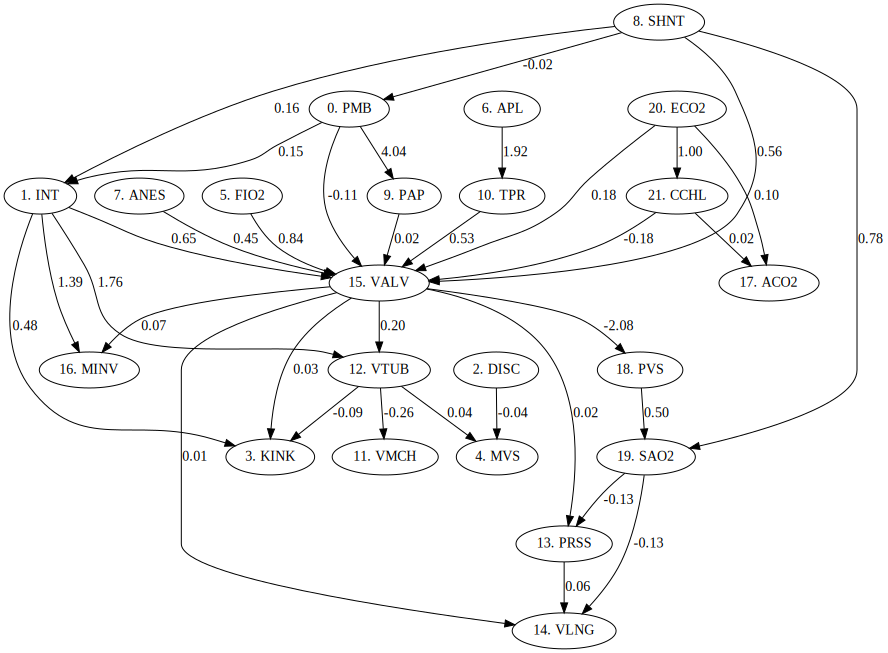

In [ ]:
model = lingam.DirectLiNGAM()
model.fit(X)
labels = [f'{i}. {col}' for i, col in enumerate(X.columns)]
make_graph(model.adjacency_matrix_, labels)

In [ ]:
import lightgbm as lgb

target = 17 # ACO2
features = [i for i in range(X.shape[1]) if i != target]
reg = lgb.LGBMRegressor(random_state=0)
reg.fit(X.iloc[:, features], X.iloc[:, target])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(X, target, reg)

df_effects = pd.DataFrame()
df_effects['feature'] = X.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,PMB,0.720307,2.170572
1,INT,1.201832,2.088741
2,DISC,1.360224,0.790068
3,KINK,0.201543,2.588390
4,MVS,0.254507,1.294680
5,FIO2,0.566558,1.346378
6,APL,1.878922,0.817098
7,ANES,1.336556,1.508800
8,SHNT,0.886308,3.116761
9,PAP,0.321253,0.597794


In [ ]:
print(df_effects.sort_values(by='effect_plus', ascending=False))

   feature  effect_plus  effect_minus
21    CCHL  2062.252911   1166.257594
20    ECO2  2029.181107   2026.369693
16    MINV    19.360158     21.029266
15    VALV     4.499266      9.578713
18     PVS     2.689711      2.486781
12    VTUB     2.546954      0.554823
19    SAO2     2.041870      1.838888
6      APL     1.878922      0.817098
2     DISC     1.360224      0.790068
7     ANES     1.336556      1.508800
1      INT     1.201832      2.088741
8     SHNT     0.886308      3.116761
13    PRSS     0.734183      0.201251
14    VLNG     0.732113      1.167821
0      PMB     0.720307      2.170572
11    VMCH     0.624872      0.056065
5     FIO2     0.566558      1.346378
10     TPR     0.546775      0.618884
9      PAP     0.321253      0.597794
4      MVS     0.254507      1.294680
3     KINK     0.201543      2.588390
17    ACO2     0.000000      0.000000


In [ ]:
print(df_effects.sort_values(by='effect_minus', ascending=False))

In [ ]:
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(X.columns[max_index[0]])

ECO2


LINEAR CASE

In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.19.5', '1.1.5', '0.10.1', '1.5.4']


In [ ]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

In [ ]:
# X = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
#                    delim_whitespace=True, header=None,
#                    names = ['mpg', 'cylinders', 'displacement',
#                             'horsepower', 'weight', 'acceleration',
#                             'model year', 'origin', 'car name'])
# X.dropna(inplace=True)
# X.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)

X = df
print(X.shape)
X.head()

(1000, 22)


,PMB,INT,DISC,KINK,MVS,FIO2,APL,ANES,SHNT,PAP,TPR,VMCH,VTUB,PRSS,VLNG,VALV,MINV,ACO2,PVS,SAO2,ECO2,CCHL
0,9.634172,2.092500,-0.820810,-1.655160,0.023484,-1.173725,-1.367037,-0.865120,2.892519,38.734281,-2.761450,0.648474,-3.203860,-14.032993,-14.178243,-73.866562,-8.245791,-738.570604,150.291648,78.226727,-5993.981357,-5606.616034
1,9.407365,2.065089,-0.897676,-1.219134,-0.099184,-0.968851,-2.407337,-1.043939,2.896333,37.207914,-4.739510,0.755557,-3.883371,-12.419035,-12.773126,-65.575416,-6.760452,-655.917825,134.135415,68.908152,-5324.112482,-4989.128290
2,9.707179,2.550885,-0.512960,-0.849870,-0.265847,-0.794231,-0.535513,-0.989653,5.662722,38.785668,-0.810877,1.241027,-5.231297,-13.205503,-13.019669,-64.076344,-5.682553,-640.500168,131.640330,70.093936,-5201.799966,-4849.138081
3,9.750950,2.240138,-1.344655,-1.957273,-0.104020,-0.863502,-2.021747,-0.922381,3.611668,39.626073,-4.349381,1.441020,-6.378893,-17.544519,-16.945620,-90.503496,-11.313400,-904.509154,187.639977,96.551917,-7337.969189,-6864.874160
4,9.983332,2.175081,-0.925939,-1.882428,0.346551,-1.065333,-1.693710,-0.898171,3.048958,39.472825,-3.493447,-1.936263,6.007108,-12.138160,-11.940216,-59.828340,-5.917730,-598.193593,122.654385,64.099181,-4857.222147,-4542.361825


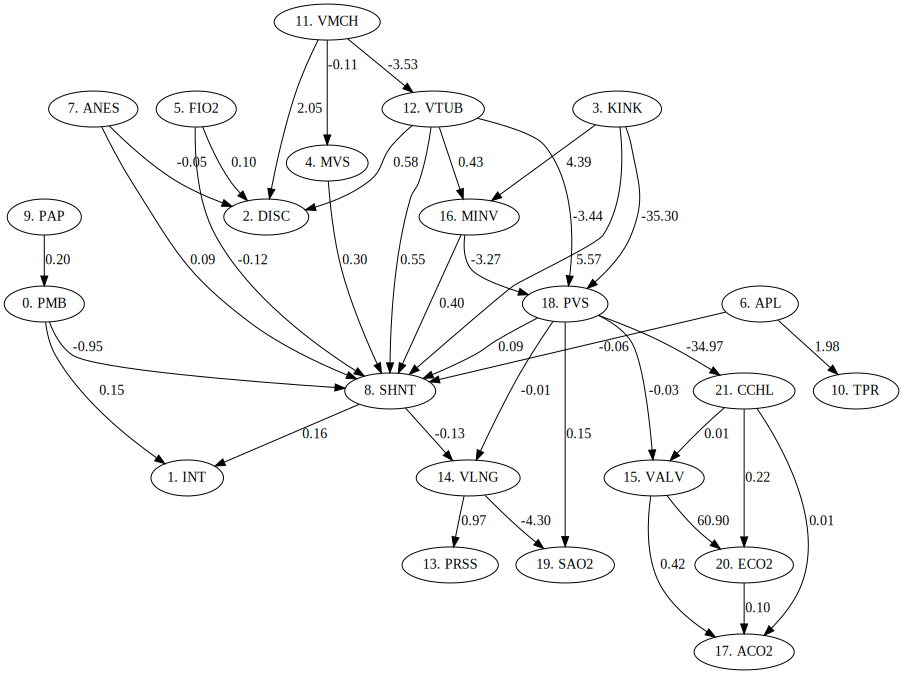

In [ ]:
model = lingam.DirectLiNGAM()
model.fit(X)
labels = [f'{i}. {col}' for i, col in enumerate(X.columns)]
make_graph(model.adjacency_matrix_, labels)

In [ ]:
from sklearn.linear_model import LinearRegression

target = 20 # ECO2
features = [i for i in range(X.shape[1]) if i != target]
reg = LinearRegression()
reg.fit(X.iloc[:, features], X.iloc[:, target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(X, target, reg)

df_effects = pd.DataFrame()
df_effects['feature'] = X.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,PMB,0.169345,0.169345
1,INT,0.037287,0.037287
2,DISC,0.005330,0.005330
3,KINK,651.397724,651.397724
4,MVS,0.050625,0.050625
5,FIO2,0.009629,0.009629
6,APL,0.019900,0.019900
7,ANES,0.002551,0.002551
8,SHNT,0.976677,0.976677
9,PAP,0.164758,0.164758


In [ ]:
print(df_effects.sort_values(by='effect_plus', ascending=False))

   feature  effect_plus  effect_minus
17    ACO2  1134.495981   1134.495981
18     PVS  1014.853262   1014.853262
21    CCHL   987.116729    987.116729
20    ECO2   958.297732    958.297732
15    VALV   768.411152    768.411152
12    VTUB   682.653461    682.653461
11    VMCH   674.160212    674.160212
3     KINK   651.397724    651.397724
16    MINV   293.821398    293.821398
14    VLNG    13.549575     13.549575
8     SHNT     0.976677      0.976677
0      PMB     0.169345      0.169345
9      PAP     0.164758      0.164758
19    SAO2     0.081895      0.081895
4      MVS     0.050625      0.050625
13    PRSS     0.047484      0.047484
1      INT     0.037287      0.037287
6      APL     0.019900      0.019900
10     TPR     0.010875      0.010875
5     FIO2     0.009629      0.009629
2     DISC     0.005330      0.005330
7     ANES     0.002551      0.002551


In [ ]:
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(X.columns[max_index[0]])

ACO2


In [ ]:
# To estimate of the intervention such that the expectation of the prediction of 
# the post-intervention observations is equal or close to a specified value, we use estimate_optimal_intervention method of CausalEffect.

# aco2 = 15
c = ce.estimate_optimal_intervention(X, target, reg, 1, 15)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: -4.465


In [ ]:
# aco2 = 21
c = ce.estimate_optimal_intervention(X, target, reg, 1, 21)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: -4.522


In [ ]:
# aco2 = 30
c = ce.estimate_optimal_intervention(X, target, reg, 1, 30)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: -4.608
